In [1]:
# ---------------------------------------------------------
# CELL 1: Import Required Libraries
# Description: Import all necessary libraries for data handling, image processing, and visualization.
# ---------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2

# For deep learning (if needed later)
import tensorflow as tf

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
# ---------------------------------------------------------
# CELL 2: Load the Dataset Metadata
# Description: Read CSV files from the RSNA Pneumonia Detection Challenge and merge them.
# ---------------------------------------------------------
# Define the path to the dataset directory
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"

# Define paths for the CSV files
labels_path = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_path = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Load the CSV files using pandas
labels_df = pd.read_csv(labels_path)
class_info_df = pd.read_csv(class_info_path)

# Merge the dataframes on 'patientId'
merged_df = pd.merge(labels_df, class_info_df, on='patientId')

# Simplify the labels: we keep only 'patientId' and 'Target', and map 0->'Normal', 1->'Pneumonia'
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
# Append ".dcm" to match the actual image filenames
labels_simple["patientId"] = labels_simple["patientId"].astype(str) + ".dcm"

print("✅ Dataset loaded and preprocessed!")
print(f"Total records: {len(labels_simple)}")


✅ Dataset loaded and preprocessed!
Total records: 26684


# Data Exploraion


Sample records:
                                  patientId     Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm     Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm     Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb.dcm     Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm     Normal
4  00436515-870c-4b36-a041-de91049b9ab4.dcm  Pneumonia

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   Target     26684 non-null  object
dtypes: object(2)
memory usage: 417.1+ KB
None

Class distribution:
Target
Normal       20672
Pneumonia     6012
Name: count, dtype: int64


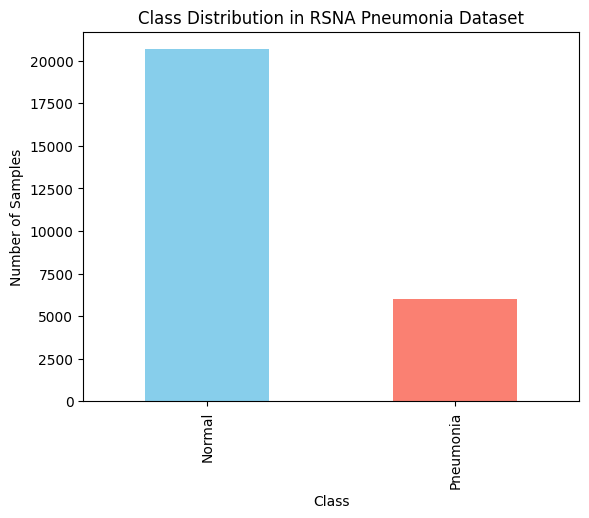

In [3]:
# ---------------------------------------------------------
# CELL 3: Explore the Dataset Metadata
# Description: Inspect the merged dataframe for insights about the dataset.
# ---------------------------------------------------------
# Display the first few rows
print("Sample records:")
print(labels_simple.head())

# Get information about the dataframe (e.g., data types, non-null counts)
print("\nDataframe Info:")
print(labels_simple.info())

# Check the distribution of classes
print("\nClass distribution:")
print(labels_simple['Target'].value_counts())

# Visualize class distribution as a bar plot
labels_simple['Target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution in RSNA Pneumonia Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


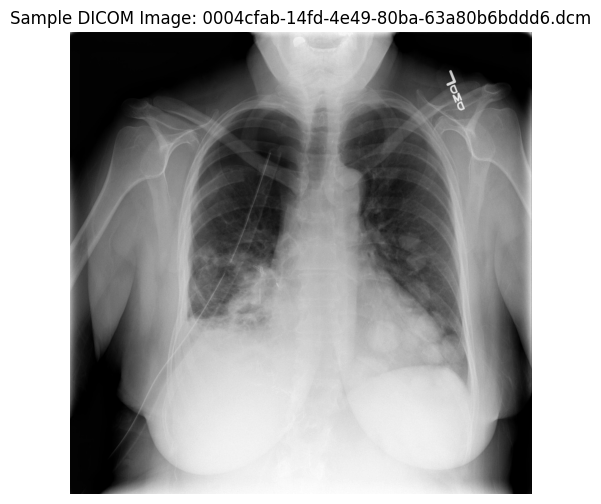

In [4]:
# ---------------------------------------------------------
# CELL 4: Inspect a Sample DICOM Image
# Description: Read and display one DICOM image from the dataset.
# ---------------------------------------------------------
# Select a sample DICOM file (for example, the first one)
sample_filename = labels_simple.iloc[0]['patientId']
sample_dicom_path = os.path.join(dataset_path, "stage_2_train_images", sample_filename)

# Read the DICOM file
dicom_sample = pydicom.dcmread(sample_dicom_path)

# Extract the pixel array and convert to float32 for visualization
img_array = dicom_sample.pixel_array.astype(np.float32)

# Normalize the image for display purposes
img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)

# Display the image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(img_norm, cmap='gray')
plt.title(f"Sample DICOM Image: {sample_filename}")
plt.axis("off")
plt.show()


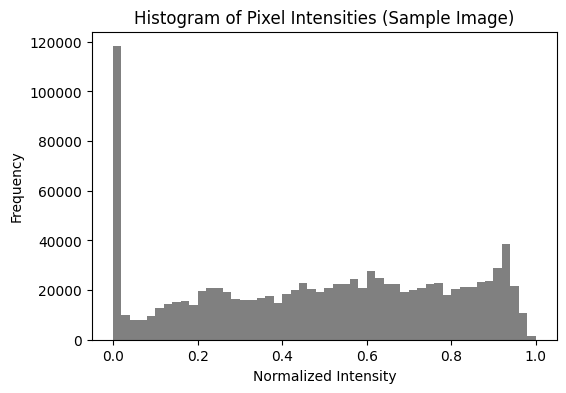

Unique labels in the dataset: ['Normal' 'Pneumonia']


In [5]:
# ---------------------------------------------------------
# CELL 5: Additional Dataset Insights
# Description: Further explore the dataset with statistics and sample visualizations.
# ---------------------------------------------------------
# Distribution of image intensities (for the sample image)
plt.figure(figsize=(6, 4))
plt.hist(img_norm.flatten(), bins=50, color='gray')
plt.title("Histogram of Pixel Intensities (Sample Image)")
plt.xlabel("Normalized Intensity")
plt.ylabel("Frequency")
plt.show()

# Check unique labels in the dataset
unique_labels = labels_simple['Target'].unique()
print("Unique labels in the dataset:", unique_labels)


In [6]:
# Check for Duplicate or Corrupted Images

unique_patients = labels_simple['patientId'].nunique()
total_rows = len(labels_simple)
print(f"Unique patients: {unique_patients}, Total rows: {total_rows}")
# If these numbers match, no duplicates remain.


Unique patients: 26684, Total rows: 26684


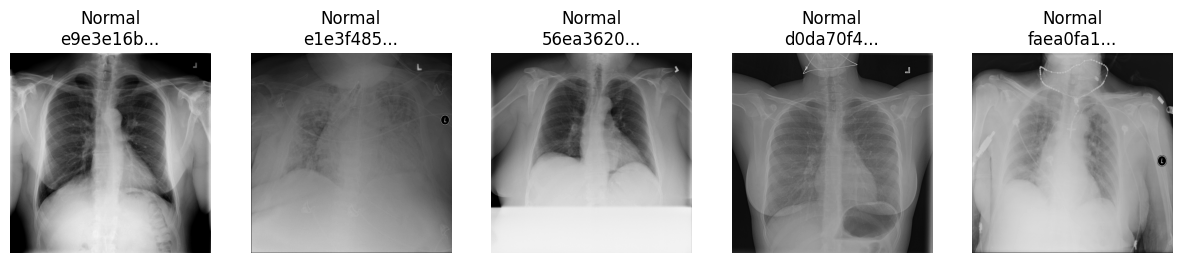

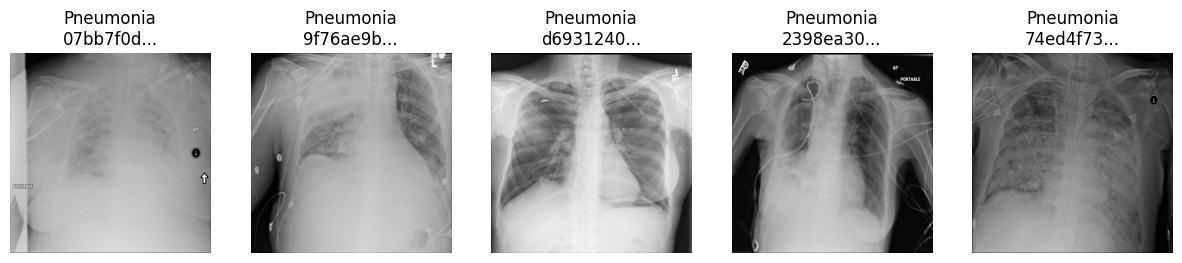

In [7]:
import random

def show_random_samples(df, label, num=5):
    # Filter for the given label
    subset = df[df['Target'] == label]
    sample_filenames = random.sample(list(subset['patientId']), num)

    plt.figure(figsize=(15, 3))
    for i, filename in enumerate(sample_filenames, 1):
        dicom_path = os.path.join(dataset_path, "stage_2_train_images", filename)
        dicom_data = pydicom.dcmread(dicom_path)
        img_array = dicom_data.pixel_array.astype(np.float32)
        img_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min() + 1e-10)

        plt.subplot(1, num, i)
        plt.imshow(img_norm, cmap='gray')
        plt.title(f"{label}\n{filename[:8]}...")
        plt.axis("off")

    plt.show()

show_random_samples(labels_simple, 'Normal', 5)
show_random_samples(labels_simple, 'Pneumonia', 5)


In [8]:
import os

missing_files = []
for pid in labels_simple['patientId']:
    if not os.path.exists(os.path.join(dataset_path, "stage_2_train_images", pid)):
        missing_files.append(pid)

print("Missing files or mislabaled:", missing_files)



Missing files or mislabaled: []


# Classificaion
